## This script demonstrates to use minimum code to run a multi-traffic signal control SUMO envorionment.  
### The enviroment is based on Tianshu Chu's large-grid env.

### First, Run the build_file.py in './envs/large_grid_data/' to generate the SUMO configuration files.

In [1]:
import gym
import numpy as np
from gym.utils import seeding # not used

#### Check SUMO is in System Environment

In [2]:
import os, sys
if 'SUMO_HOME' in os.environ:
	tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
	sys.path.append(tools)
else:
	sys.exit("please declare environment variable 'SUMO_HOME'")

In [3]:
from sumolib import checkBinary 
import traci
# sumoBinary = checkBinary('sumo')
# sumoBinary = checkBinary('sumo-gui')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### TrafficLight: an agent with states

Several internal varibles in the TrafficLight class in this script may not be used.

In [5]:
class TrafficLight:
    def __init__(self, name):
        self.name = name
#         self.controlled_lanes = []
        self.state_num = 0  
        self.lanes_in = [] # this lanes comes from traci.trafficlight.getControlledLanes(), which may have duplicated names
        self.ilds_in = [] # this the lanes without duplicated names (a lane may have vehicles heading to different directions)
        self.state = [] # number of vehicles on each lane (ilds)
        
        self.phase_id = -1
        self.prev_action = -1

### Grid Environment

This environment is identical to the large grid env. The phases are hard coded. The SUMO configuration files, including xxx.net.xml, xxx.rou.xml, xxx.sumocfg, etc., are the default files generated by the build_file.py.

In [6]:
PHASE_NUM = 5

class GridEnv(gym.Env):
    def __init__(self, phase_num, gui=False):
        self.phase_num = phase_num
        self.seed()
        self.gui = gui
        self.sim = self._init_sim(self.gui)
        self.nodes, self.node_names = self._init_nodes()
#         self.state_space = None
        self._init_action_space()
        self._init_state_space()
        self.state_approching_vehicle = []
        self.cur_sec = 0
        self.episode_length_sec = 3600

        self.cur_episode = 0
        self.control_interval_sec = 5
        self.yellow_interval_sec = 2
        
        self.phases = ['GGgrrrGGgrrr', 'rrrGrGrrrGrG', 'rrrGGrrrrGGr',
                  'rrrGGGrrrrrr', 'rrrrrrrrrGGG']
        
        
    def seed(self, seed=None):
        """
        Create random seed, useless here as the env is deterministic
        
        Parameters
        ----------
            param seed: the random seed
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def _init_sim(self, gui):
        '''
        Init simulation. The sumo configuration file is the generated file in the envs folder. 
        
        Parameters
        ----------
            gui: indicating whether start the gui
            
        Returns
        -------
            a SUMO traci connection for controlling the simulation env
        '''
        sumoBinary = checkBinary('sumo')
        if gui:
            sumoBinary = checkBinary('sumo-gui')
        traci.start([sumoBinary, "-c", "./envs/large_grid_data/exp.sumocfg"], label='sim1')
        return traci.getConnection("sim1")
    
    
    def _init_nodes(self):
        '''
        Init the nodes (traffic signals)
        
        Parameters
        ----------
            gui: indicating whether start the gui
            
        Returns
        -------
            nodes: a set of TrafficLights
            a sorted list of the names of the nodes
        '''
        nodes = {}
        for node_name in self.sim.trafficlight.getIDList():
            nodes[node_name] = TrafficLight(node_name)
            controlled_lanes = self.sim.trafficlight.getControlledLanes(node_name)
#             nodes[node_name].controlled_lanes = controlled_lanes 
            ilds_in = []
            for lane_name in controlled_lanes:
                ild_name = lane_name
                if ild_name not in ilds_in:
                    ilds_in.append(ild_name)
            nodes[node_name].ilds_in = ilds_in
#             nodes[node_name].state_num = 
        return nodes, sorted(list(nodes.keys()))
    
    
    def _init_action_space(self):
        self.n_a_ls = []
        for node_name in self.node_names:
            node = self.nodes[node_name]
            node.n_a = self.phase_num
            self.n_a_ls.append(node.n_a)
        self.action_space = np.prod(np.array(self.n_a_ls))
        
        
    def _init_state_space(self):
        self.n_s_ls = [] # a list of number of state of each node
        for node_name in self.node_names:
            node = self.nodes[node_name]
            node.num_state = len(node.ilds_in)
            self.n_s_ls.append(node.num_state)
        self.state_space = np.sum(np.array(self.n_s_ls))
    
    
    def _get_node_action_phase(self, action, node_name, phase_type):
        '''
        Get the node's next phase given an action. 
        
        If the phase_type is green, it returns current phase.
        If the phase_type is yellow, it returns a switching phase, 
        in which the green lanes ('G' or 'g') of the previous phase will be changed into yellow ('y') 
        and the green lanes ('G' or 'g') of the current phase will be changed into red ('r').
        
        Parameters
        ----------
            action: action of the node
            node_name: name of the node
            phase_type: 'green' or 'yellow'
            
        Returns
        -------
            list: a list of strings representing the next phase of the node
        '''
        node = self.nodes[node_name]
        cur_phase = self.phases[int(action)]
        if phase_type == 'green':
            return cur_phase
        prev_action = node.prev_action
        node.prev_action = action
        if (prev_action < 0) or (action == prev_action):
            return cur_phase
        prev_phase = self.phases[int(prev_action)]
        switch_reds = []
        switch_greens = []
        for i, (p0, p1) in enumerate(zip(prev_phase, cur_phase)):
            if (p0 in 'Gg') and (p1 == 'r'):
                switch_reds.append(i)
            elif (p0 in 'r') and (p1 in 'Gg'):
                switch_greens.append(i)
        if not len(switch_reds):
            return cur_phase
        yellow_phase = list(cur_phase)
        for i in switch_reds:
            yellow_phase[i] = 'y'
        for i in switch_greens:
            yellow_phase[i] = 'r'
        return ''.join(yellow_phase)
    
    
    def _set_phase(self, actions, phase_type, phase_duration):
        '''
        set next phases of all nodes given actions
        
        Parameters
        ----------
            actions: action of all nodes
            phase_type: 'green' or 'yellow'
            phase_duration: duration of phase
        '''
        for node_name, action in zip(self.node_names, list(actions)):
            phase = self._get_node_action_phase(action, node_name, phase_type)
            self.sim.trafficlight.setRedYellowGreenState(node_name, phase)
            self.sim.trafficlight.setPhaseDuration(node_name, phase_duration)
    
    
    def _simulate(self, num_step):
        for _ in range(num_step):
            self.sim.simulationStep()
            self.cur_sec += 1
            
            
    def _get_state(self):
        state = []
        for node_name in self.node_names:
            node = self.nodes[node_name]
            cur_state = []
            for ild in node.ilds_in:
                cur_num_vehicle = self.sim.lanearea.getLastStepVehicleNumber(ild)
                cur_state.append(cur_num_vehicle)
            cur_state = np.array(cur_state)
            node.state = cur_state
            state.append(node.state)
        return np.array(state) 
    
    
    def _get_reward_step(self):
        rewards = []
        for node_name in self.node_names:
            queues = []
            for ild in self.nodes[node_name].ilds_in:
                cur_queue = self.sim.lanearea.getLastStepHaltingNumber(ild)
                queues.append(cur_queue)
            queue = np.sum(np.array(queues)) if len(queues) else 0
            reward = - queue
            rewards.append(reward)
        return np.array(rewards)
    
    
    def step(self, action):
        self._set_phase(action, 'yellow', self.yellow_interval_sec)
        self._simulate(self.yellow_interval_sec)
        rest_interval_sec = self.control_interval_sec - self.yellow_interval_sec
        self._set_phase(action, 'green', rest_interval_sec)
        self._simulate(rest_interval_sec)
        state = self._get_state()
        reward = self._get_reward_step()
        done = False
        if self.cur_sec >= self.episode_length_sec:
            done = True
        global_reward = np.sum(reward) # for fair comparison
        return state, reward, done, global_reward
    
    
    def reset(self):
        for node_name in self.node_names:
            node = self.nodes[node_name]
            # prev action for yellow phase before each switch
            node.prev_action = 0
        self.cur_sec = 0
        self.cur_episode += 1
        return self._get_state()
    
    def terminate(self):
        self.sim.close()

In [7]:
class Policy:
    def __init__(self, node_names, name = 'greedy'):
        self.node_names = node_names
        self.name = 'greedy'

    def forward(self, states):
        actions = []
        for state, node_name in zip(states, self.node_names):
            if self.name == 'greedy':
                action = self.greedy_policy(state)
            else:
                action = self.random_policy(state)
            actions.append(action)
        return actions
    
    def random_policy():
        actions = []
        for node_name in self.node_names:
            action = np.random.randint(5, size= 1)
            actions.append(action)
        actions = np.squeeze(np.array(actions))
        return actions
    
    def greedy_policy(self, ob):
        # hard code the mapping from state to number of cars
        flows = [ob[0] + ob[3], ob[2] + ob[5], ob[1] + ob[4],
                 ob[1] + ob[2], ob[4] + ob[5]]
        actions = np.argmax(np.array(flows))
        return actions

In [8]:
env = GridEnv(phase_num = 5, gui = True)
policy = Policy(env.node_names, name = 'greedy')
rewards = []
state = env.reset()
while True:
    action = policy.forward(state)
    next_state, _, done, global_reward = env.step(action)
    rewards.append(global_reward)
    if done:
        break
    state = next_state
env.terminate()

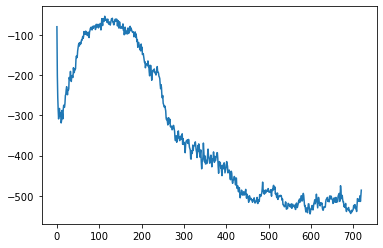

In [9]:
plt.plot(np.array(rewards))